## <p>Обучите линейную регрессию для предсказания шансов на поступление в университет.</p>

<p><strong>Требования к анализу:</strong></p>

<ol>
	<li>Проведите первичный анализ данных</li>
	<li>Проведите визуальный анализ данных</li>
	<li>Разбейте данные на обучение и тест</li>
  <li>Обучите модель регрессии, с целевым признаком Chance of Admit (изменяется от 0 до 1).</li>
  <li>Оцените подходящие метрики качества</li>
  <li>Сформулируйте выводы по проделанной работе</li>
</ol>

In [6]:
!python -m wget https://drive.google.com/uc?id=149EjiR3PUEmotXbtfDvYU_hBZPH8Kl3m -o adm_data.csv


Saved under adm_data.csv


**Подключение библиотек и скриптов**

In [7]:
# 1. Основные библиотеки
import pandas as pd
import numpy as np
import pickle #сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

**Пути к директориям и файлам**

In [8]:
DATASET_PATH = 'adm_data.csv'
PREPARED_DATASET_PATH_TRAIN = 'adm_data_train.csv'
PREPARED_DATASET_PATH_TEST = 'adm_data_test.csv'

SCALER_FILE_PATH ='scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

## Первичный анализ данных
****

In [9]:
df = pd.read_csv(DATASET_PATH, sep=',')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [10]:
df.shape

(400, 9)

In [11]:
df.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [12]:
df.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [14]:
double = df.duplicated().sum()
print(double)

0


**Пропусков в данных нет. Типы признаков числовые и вещественные. Дублирующих строк в датасете нет. Небольшая магия с переименованием столбцов таблицы.**

In [15]:
df.rename(columns=lambda c: c.lower().strip().replace(' ', '_').replace('.', ''), inplace=True)

In [16]:
df.head()

,serial_no,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


**Основные статитики по вещественным и числовым признакам исключая признак serial_no.**

In [17]:
df.loc[:, df.columns != 'serial_no'].describe()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


## Визуальный анализ данных
****

**Матрица корреляции снова без признака serial_no. Таргет признак достаточно сильно зависит от признаков gre_score, toefl_score и cgpa. Остальные признаки также неплохо кррелируют с целевым признаком. С данными при построении матрицы корреляции ничего не делала.**

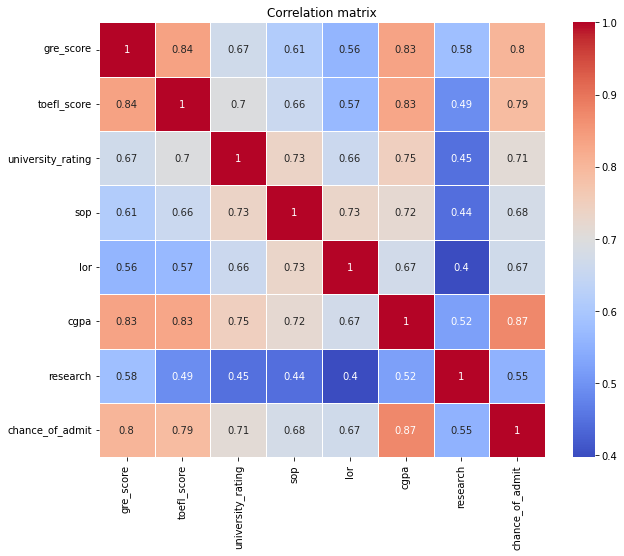

In [18]:
plt.figure(figsize=(10, 8))
corr_matrix = df.loc[:, df.columns != 'serial_no'].corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Для каждого признака построила гистограмму. По графикам видно, что данные представлены хорошие, нет никаких хвостов ни справа, ни слева.**

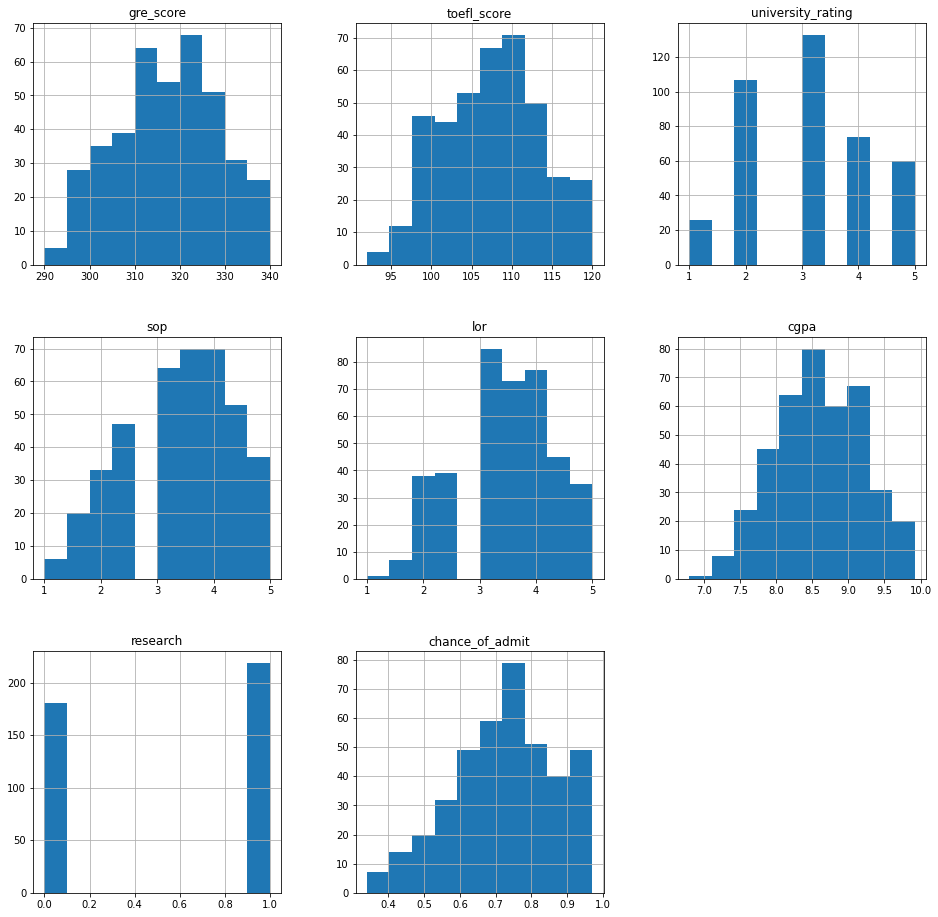

In [19]:
df.loc[:, df.columns != 'serial_no'].hist(figsize=(16, 16), grid=True);

**Создаю дополнительный датафррейм, путем копирования основного для построения countplot-графиков. И еще те признаки, у которых уникальных значений очень много (больше 10), я группирую по квартилям (25%, 50%, 75%) В итоге получаются 4 группы признаков.  С признаком chance_of_admit поступаю также. В итоге получаю серию countplot-графиков, в которых видно, что у групп с бОльшими значениями признаков бОльшую часть составляют те, у кого бОльший chance_of_admit. Ничего неожиданного.**

In [20]:
df1 = df.copy()
df1 = df1.loc[:, df.columns != 'serial_no']

In [21]:
df1.head()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [22]:
for c in df.columns:
  print(f'Признак {c}, медиана {df[c].median()}, кол-во уник значений {df[c].nunique()}')

Признак serial_no, медиана 200.5, кол-во уник значений 400
Признак gre_score, медиана 317.0, кол-во уник значений 49
Признак toefl_score, медиана 107.0, кол-во уник значений 29
Признак university_rating, медиана 3.0, кол-во уник значений 5
Признак sop, медиана 3.5, кол-во уник значений 9
Признак lor, медиана 3.5, кол-во уник значений 9
Признак cgpa, медиана 8.61, кол-во уник значений 168
Признак research, медиана 1.0, кол-во уник значений 2
Признак chance_of_admit, медиана 0.73, кол-во уник значений 60


In [23]:
for c in df.columns:
  if c != 'serial_no' and df[c].nunique() > 10:
      quantiles = list(df[c].quantile([0.25,0.5,0.75]))
      df1.loc[df[c] < quantiles[0], c] = 0
      df1.loc[(df[c] >= quantiles[0]) & (df[c] < quantiles[1]), c] = 1
      df1.loc[(df[c] >= quantiles[1]) & (df[c] < quantiles[2]), c] = 2
      df1.loc[df[c] >= quantiles[2], c] = 3


In [24]:
df1.head()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,3,3,4,4.5,4.5,3.0,1,3.0
1,2,2,4,4.0,4.5,2.0,1,2.0
2,1,1,3,3.0,3.5,0.0,1,1.0
3,2,2,3,3.5,2.5,2.0,1,2.0
4,1,1,2,2.0,3.0,1.0,0,1.0


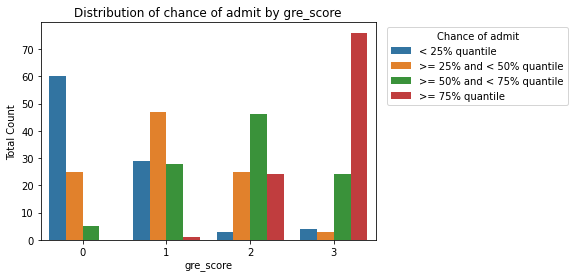

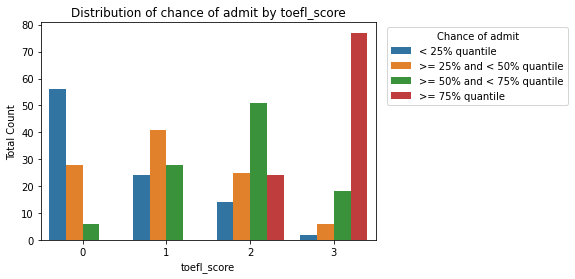

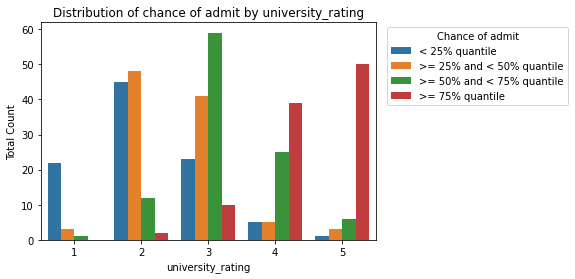

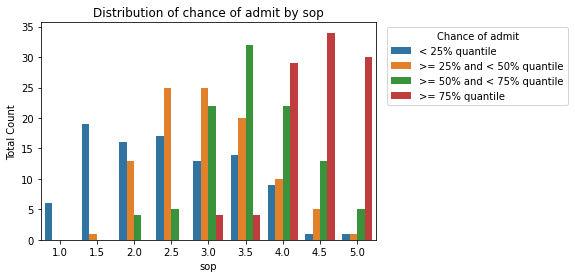

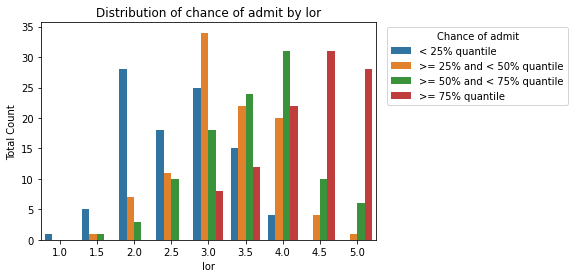

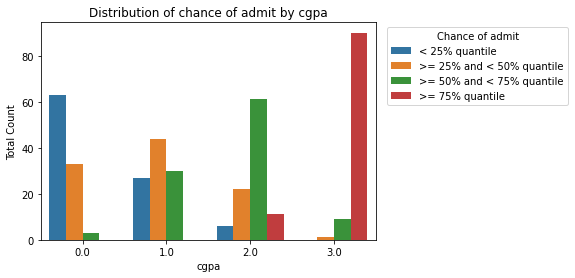

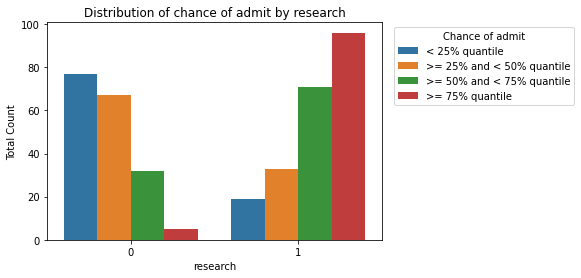

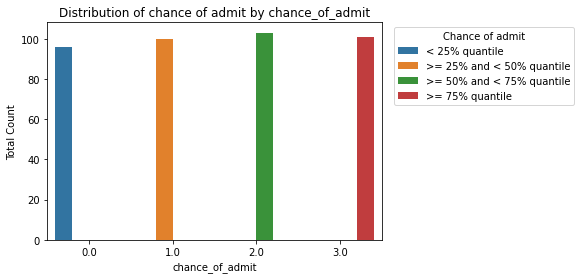

In [25]:
for i, col in enumerate(df1.columns):
    plt.figure(i)
    sns.countplot(x=col, data=df1, hue='chance_of_admit')
    plt.ylabel('Total Count')
    plt.title(f'Distribution of chance of admit by {col}')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Chance of admit', labels=['< 25% quantile', '>= 25% and < 50% quantile', '>= 50% and < 75% quantile', '>= 75% quantile']);

## Разбиение на train / test
****

In [26]:
X = df.drop(columns=['chance_of_admit'])
y = df.chance_of_admit

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=100)

## Предобработка данных и Feature engineering
****

In [27]:
df.shape

(400, 9)

In [28]:
df.head()

,serial_no,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [29]:
df.describe()

,serial_no,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


**Так как нет никаких огромных значений-выбросов и категориальных признаков, я сделаю небольшую трансформацию данных, избавившись от признака serial_no, который никакой смысловой нагрузки не несет.**

In [30]:
class DataPipeline:

  def __init__(self):
    pass

  def fit(self, df):
    pass

  def transform(self, df):
    if 'serial_no' in df.columns:
      df.drop(columns='serial_no', inplace=True)
    return df

In [31]:
pipe = DataPipeline()

In [32]:
X_train = pipe.transform(X_train_orig)
X_test = pipe.transform(X_test_orig)

In [33]:
X_test.shape

(120, 7)

In [34]:
X_test.head(2)

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research
248,324,110,3,3.5,4.0,8.87,1
318,324,111,3,2.5,2.0,8.80,1


### **Масштабирование признаков**
**Так как решается задача линейной регрессии, то в качестве масштабирования признаков необходимо выполнить стандартизацию.**

In [35]:
feature_names_for_stand = X_train.columns
feature_names_for_stand

Index(['gre_score', 'toefl_score', 'university_rating', 'sop', 'lor', 'cgpa',
       'research'],
      dtype='object')

In [36]:
scaler = StandardScaler()
stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_test = scaler.transform(X_test[feature_names_for_stand])

In [37]:
scaler.mean_, scaler.var_

(array([317.12857143, 107.63928571,   3.1       ,   3.4375    ,
          3.47678571,   8.62910714,   0.55714286]),
 array([130.61918367,  36.50202806,   1.29      ,   1.02377232,
          0.80035395,   0.35730456,   0.24673469]))

In [38]:
stand_features_train

array([[ 1.12622009,  0.88728709,  1.67285672, ...,  0.58484199,
         1.13909383,  0.89155583],
       [ 0.42623868,  0.39073735,  1.67285672, ...,  0.58484199,
         0.78777614,  0.89155583],
       [ 1.47621079,  1.54935341,  1.67285672, ...,  1.14373536,
         0.7375879 ,  0.89155583],
       ...,
       [-1.06122181, -0.93339528, -0.968496  , ..., -1.09183812,
        -0.75132992, -1.12163475],
       [-0.53623576, -0.93339528, -0.08804509, ...,  0.58484199,
         0.01822311,  0.89155583],
       [-1.32371484, -0.93339528, -1.8489469 , ..., -2.20962486,
        -1.05245936, -1.12163475]])

In [39]:
X_train[feature_names_for_stand] = stand_features_train
X_test[feature_names_for_stand] = stand_features_test

In [40]:
X_train.head()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research
234,1.126220,0.887287,1.672857,1.544253,0.584842,1.139094,0.891556
45,0.426239,0.390737,1.672857,1.544253,0.584842,0.787776,0.891556
171,1.476211,1.549353,1.672857,0.555931,1.143735,0.737588,0.891556
47,1.913699,1.880387,1.672857,1.050092,0.584842,1.791541,-1.121635
265,-0.361240,-0.933395,-0.088045,-0.926552,-1.091838,0.085141,-1.121635


In [41]:
X_train.describe()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research
count,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02,2.800000e+02
mean,-4.440892e-16,-8.628019e-16,-8.881784e-17,1.903239e-17,1.268826e-16,5.963484e-16,-6.344132e-18
std,1.001791e+00,1.001791e+00,1.001791e+00,1.001791e+00,1.001791e+00,1.001791e+00,1.001791e+00
min,-2.373687e+00,-2.588561e+00,-1.848947e+00,-2.409034e+00,-2.209625e+00,-3.059989e+00,-1.121635e+00
25%,-6.456079e-01,-7.678787e-01,-9.684960e-01,-9.265515e-01,-5.329447e-01,-7.178711e-01,-1.121635e+00
50%,-1.124970e-02,-2.305409e-02,-8.804509e-02,6.177010e-02,2.594862e-02,1.822311e-02,8.915558e-01
75%,6.887317e-01,7.217705e-01,7.924058e-01,5.559309e-01,5.848420e-01,7.543173e-01,8.915558e-01
max,2.001197e+00,2.045903e+00,1.672857e+00,1.544253e+00,1.702629e+00,2.159588e+00,8.915558e-01


### **Сохранение  датасета**

In [42]:
X_train.to_csv(PREPARED_DATASET_PATH_TRAIN, index=False, sep=';')
X_test.to_csv(PREPARED_DATASET_PATH_TEST, index=False, sep=';')

## Построение моделей
****

In [43]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""

    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )

    plt.figure(figsize=(8, 8))

    sns.scatterplot(x=pred_values, y=true_values)
    #plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # диагональ, где true_values = pred_values

    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')

    if save == True:
        plt.savefig('report.png')
    plt.show()

In [44]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [45]:
# коэффициенты модели
lr_model.coef_

array([ 0.01383116,  0.02056942,  0.00775454, -0.01019736,  0.02436933,
        0.07698885,  0.01143176])

In [46]:
# свободный сдвиг
lr_model.intercept_

0.7274285714285714

In [47]:
# предсказания
y_train_preds = lr_model.predict(X_train)
y_train_preds.shape

(280,)

In [48]:
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=0, a_max=1)

R2:	0.802
RMSE:	0.064
MSE:	0.004


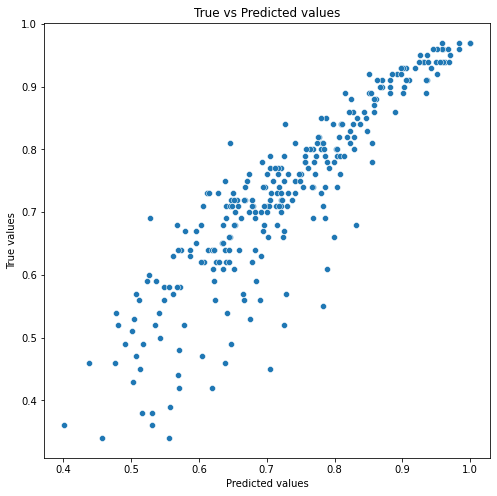

In [49]:


evaluate_preds(y_train, y_train_preds)

R2:	0.8
RMSE:	0.061
MSE:	0.004


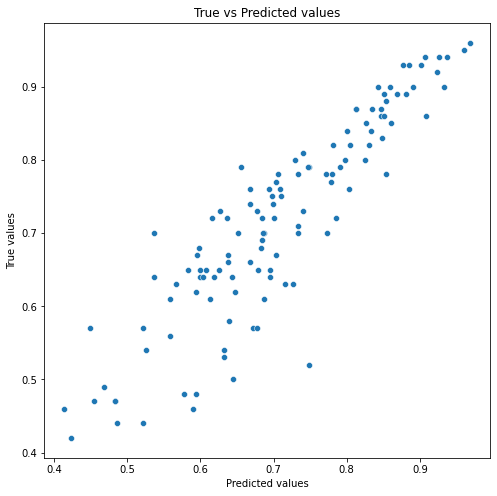

In [50]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

# Улучшение модели
****

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataPipeline(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, df, y=None):
    return self

  def transform(self, df, y=None):
    if 'serial_no' in df.columns:
      df.drop(columns='serial_no', inplace=True)
    return df

In [52]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    DataPipeline(),
    StandardScaler()
)
pipe

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('standardscaler', StandardScaler())])

In [53]:
pipe.fit(X_train_orig, y_train)

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('standardscaler', StandardScaler())])

In [54]:
X_train = pipe.transform(X_train_orig)
X_test = pipe.transform(X_test_orig)

R2:	0.802
RMSE:	0.064
MSE:	0.004


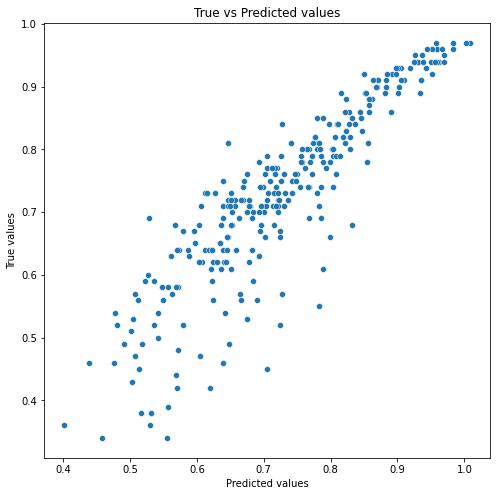

In [55]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)

evaluate_preds(y_train, y_train_preds)

R2:	0.8
RMSE:	0.061
MSE:	0.004


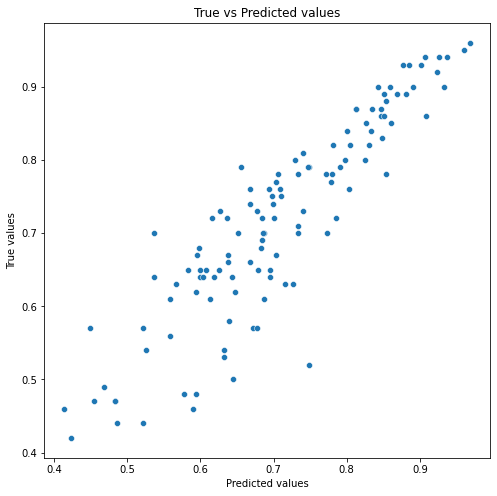

In [56]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### **PolynomialFeature**

In [57]:
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    DataPipeline(),
    #SimpleImputer(strategy='median'),
    PolynomialFeatures(interaction_only=True),
    StandardScaler()
)
pipe

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('standardscaler', StandardScaler())])

In [58]:
X_train = pipe.fit_transform(X_train_orig)
X_test = pipe.transform(X_test_orig)

R2:	0.821
RMSE:	0.061
MSE:	0.004


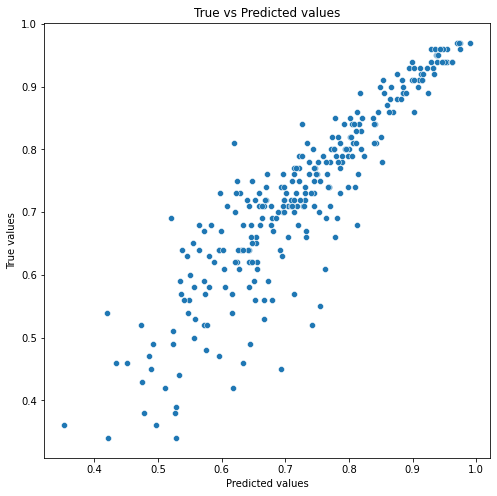

In [59]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
#y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.774
RMSE:	0.065
MSE:	0.004


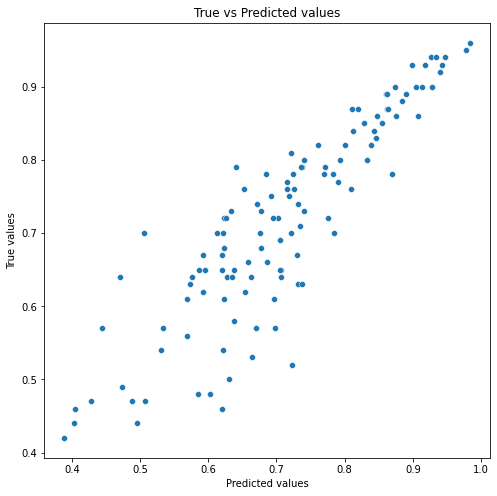

In [60]:
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
#y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

In [61]:
pipe = make_pipeline(
    DataPipeline(),
    #SimpleImputer(strategy='median'),
    PolynomialFeatures(degree=3),
    StandardScaler()
)
pipe

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler())])

In [62]:
X_train = pipe.fit_transform(X_train_orig)
X_test = pipe.transform(X_test_orig)

R2:	0.882
RMSE:	0.05
MSE:	0.002


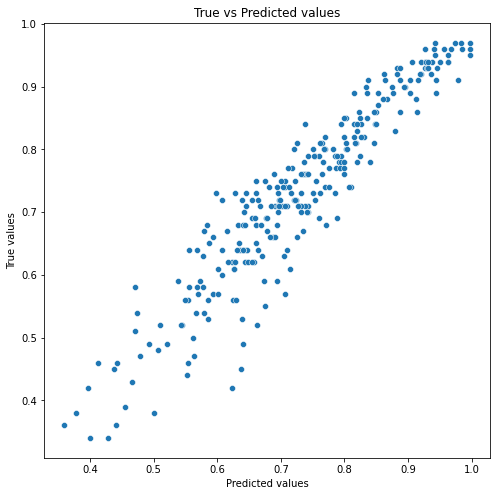

In [63]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
#y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.348
RMSE:	0.11
MSE:	0.012


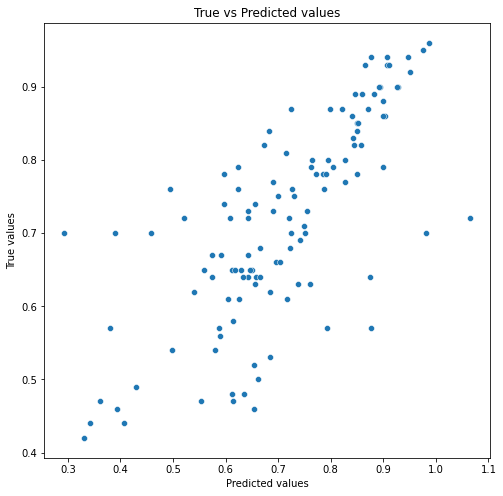

In [ ]:
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
#y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

**Вывод:** я меняла значения параметров test_size = [0.3, 0.2, 0.1] и random_state = [42, 100] в методе train_test_split в пункте Разбиение на train/test. Беря по очередно различные значения test_size и random_state и применяя к данным различные пайплайны: просто StandardScaler(), PolynomialFeature(interaction_only=True) и StandardScaler(), PolynomialFeature(degree=3) и StandardScaler(), у меня получился набор из 18 различных значений метрик R2, RMSE, MSE. Максимальное значение метрик у меня получилось при random_state=100, test_size=0.1 и в качестве пайплайна использовать просто StandardScaler(). R2: 0.851, RMSE: 0.054, MSE: 0.003. Я так понимаю, что это просто удачное стечение обстоятельств и не факт, что коэффициенты линейной модели, найденные при описанных выше условиях, на свежих тестовых данных покажут себя хорошо.